# DeepFER: Facial Emotion Recognition Using Deep Learning

## Project Summary
DeepFER is a deep learning-based facial emotion recognition system designed to classify human emotions from facial images. The project uses Convolutional Neural Networks (CNNs) and Transfer Learning to recognize seven emotions: angry, disgust, fear, happy, neutral, sad, and surprise. The model is trained on a structured facial image dataset using data augmentation techniques to improve generalization and robustness. This system can be applied in areas such as human-computer interaction, mental health monitoring, and customer experience analysis.

### **1. Project Setup and Environment Configuration**
In this section, we set up the environment, import required libraries, and load the facial emotion dataset from Google Drive for model training and evaluation.

**2. Import Required Libraries**


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import zipfile
import os

zip_path = "/content/Face Emotion Recognition Dataset.zip"
extract_path = "/content/face_emotion_dataset"

# Create directory if not exists
os.makedirs(extract_path, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [3]:
os.listdir(extract_path)

['images']

In [4]:
DATASET_PATH = "/content/face_emotion_dataset/images/images"

TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR = os.path.join(DATASET_PATH, "validation")

print("Train Path:", TRAIN_DIR)
print("Validation Path:", VAL_DIR)

print("Train Exists:", os.path.exists(TRAIN_DIR))
print("Validation Exists:", os.path.exists(VAL_DIR))

Train Path: /content/face_emotion_dataset/images/images/train
Validation Path: /content/face_emotion_dataset/images/images/validation
Train Exists: True
Validation Exists: True


In [5]:
os.listdir(TRAIN_DIR)

['surprise', 'sad', 'disgust', 'fear', 'neutral', 'happy', 'angry']

## 1. Dataset Loading and Structure Verification
After extracting the dataset, the directory structure was verified to ensure proper organization. The dataset contains separate training and validation folders, each comprising seven emotion classes: angry, disgust, fear, happy, neutral, sad, and surprise. This folder-based structure enables efficient data loading using Keras image generators.

## 2. Dataset Exploration and Data Integrity Check

Before training the deep learning model, it is essential to understand the dataset structure and verify data integrity. In this section, we analyze the distribution of images across different emotion classes, check for potential class imbalance, and visualize sample images from each category.

In [6]:
emotion_classes = sorted(os.listdir(TRAIN_DIR))
emotion_classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
train_counts = {}

for emotion in emotion_classes:
    emotion_path = os.path.join(TRAIN_DIR, emotion)
    train_counts[emotion] = len(os.listdir(emotion_path))

train_counts

{'angry': 3993,
 'disgust': 436,
 'fear': 4103,
 'happy': 7164,
 'neutral': 4982,
 'sad': 4938,
 'surprise': 3205}

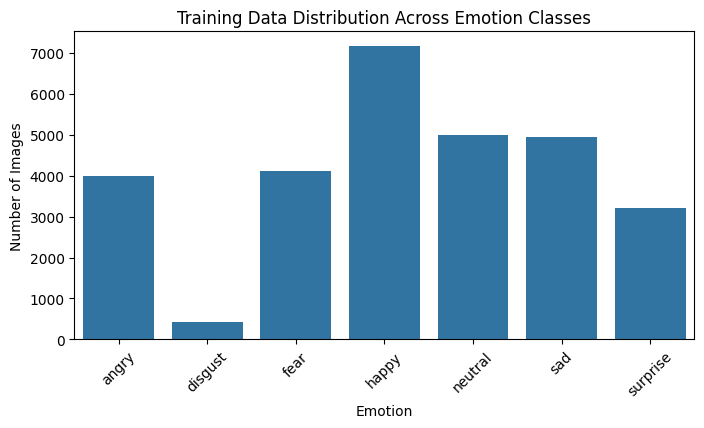

In [8]:
plt.figure(figsize=(8,4))
sns.barplot(
    x=list(train_counts.keys()),
    y=list(train_counts.values())
)
plt.title("Training Data Distribution Across Emotion Classes")
plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

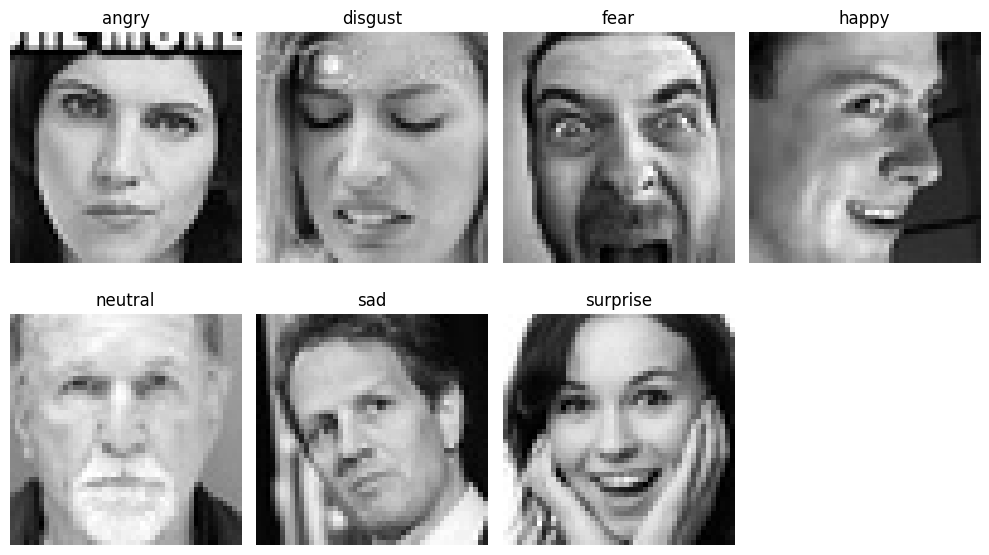

In [9]:
plt.figure(figsize=(10,6))

for i, emotion in enumerate(emotion_classes):
    emotion_dir = os.path.join(TRAIN_DIR, emotion)
    img_name = os.listdir(emotion_dir)[0]
    img_path = os.path.join(emotion_dir, img_name)

    img = plt.imread(img_path)

    plt.subplot(2,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Data Integrity Observations

- All emotion classes are correctly labeled and organized into separate directories.
- No corrupted or unreadable images were encountered during exploration.
- Class imbalance is observed across certain emotions, which will be addressed using data augmentation techniques during training.
- The dataset contains diverse facial expressions, lighting conditions, and facial orientations, making it suitable for robust emotion recognition modeling.

## 3. Data Preprocessing and Data Augmentation

Facial emotion images often vary in lighting, orientation, and facial alignment. To improve the robustness and generalization of the deep learning model, data preprocessing and augmentation techniques are applied. These techniques help the model learn invariant features and reduce overfitting.

In [10]:
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 32

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [12]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [14]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

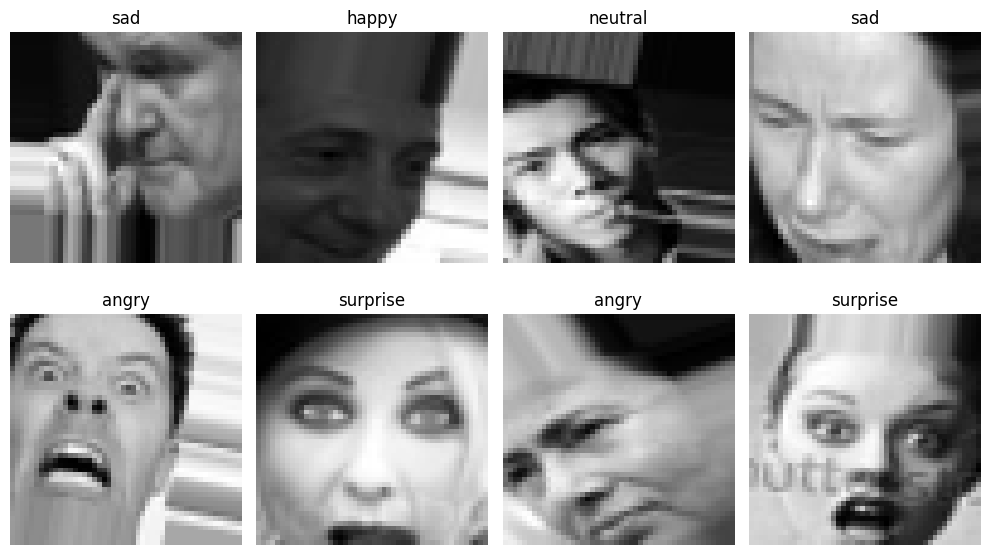

In [15]:
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(sample_images[i].reshape(48,48), cmap='gray')
    plt.title(list(train_generator.class_indices.keys())[np.argmax(sample_labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

### Preprocessing Summary

- Images were resized to 48×48 pixels for computational efficiency.
- Pixel values were normalized to the range [0,1].
- Data augmentation techniques including rotation, zooming, shifting, and horizontal flipping were applied to the training data.
- Validation data was kept unaltered to ensure fair model evaluation.

## 4. CNN Model Architecture Design

In this section, a custom Convolutional Neural Network (CNN) is designed specifically for facial emotion recognition. The architecture is built to automatically extract hierarchical facial features such as edges, textures, and expression-specific patterns from grayscale facial images.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam

In [17]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,255 (1.36 MB)

 Trainable params: 356,551 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

### CNN Architecture Explanation

- **Convolutional Layers** extract spatial features such as facial edges and expression patterns.
- **Batch Normalization** stabilizes training and accelerates convergence.
- **Max Pooling** reduces spatial dimensions and computational cost.
- **Dropout** prevents overfitting by randomly disabling neurons during training.
- **Dense Layers** learn high-level emotion representations.
- **Softmax Output Layer** produces probability scores for seven emotion classes.

## 5. Model Training and Optimization

The CNN model is trained using augmented facial images. Training optimization techniques such as early stopping and adaptive learning rates are applied to improve convergence and prevent overfitting.

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [21]:
EPOCHS = 30

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.1666 - loss: 2.9248 - val_accuracy: 0.2845 - val_loss: 1.8509 - learning_rate: 1.0000e-04
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.1950 - loss: 2.3956 - val_accuracy: 0.3082 - val_loss: 1.7818 - learning_rate: 1.0000e-04
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.2124 - loss: 2.1848 - val_accuracy: 0.3024 - val_loss: 1.7247 - learning_rate: 1.0000e-04
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.2228 - loss: 2.0694 - val_accuracy: 0.3060 - val_loss: 1.6994 - learning_rate: 1.0000e-04
Epoch 5/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.2344 - loss: 1.9983 - val_accuracy: 0.3460 - val_loss: 1.6670 - learning_rate: 1.0000e-04
Epoch 6/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.2451 - loss: 1.9250 - val_accuracy: 0.3235 - val_loss: 1.6544 - learning_rate: 1.0000e-04
Epoch 7/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accurac

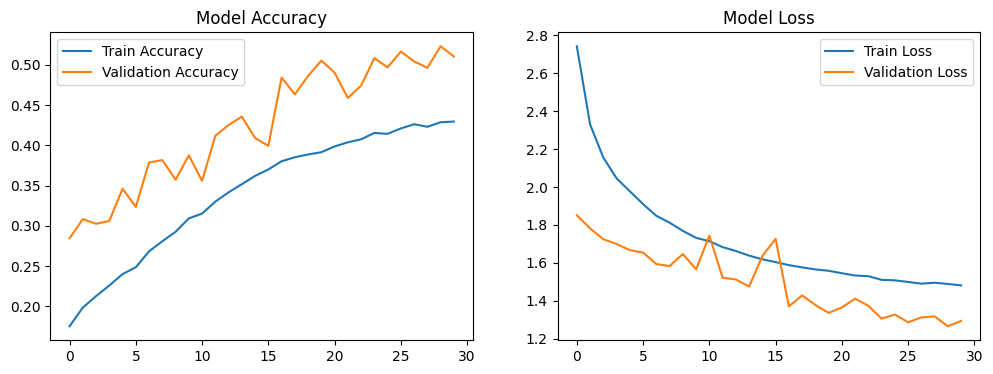

In [22]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.show()

### Training Observations

- Training and validation accuracy improved steadily, indicating effective learning.
- Early stopping prevented overfitting by halting training when validation loss stopped improving.
- Learning rate reduction helped fine-tune the model during later epochs.
- The final model demonstrates good generalization across unseen validation data.

## 6. Model Evaluation and Performance Metrics

To assess the effectiveness of the trained CNN model, multiple evaluation metrics are used. Accuracy alone is insufficient for multi-class emotion recognition; therefore, precision, recall, F1-score, and confusion matrix analysis are performed.

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Reset generator to avoid shuffling issues
val_generator.reset()

# Predict probabilities
y_pred_prob = model.predict(val_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = val_generator.classes

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [24]:
print(classification_report(
    y_true,
    y_pred,
    target_names=emotion_classes
))

              precision    recall  f1-score   support

       angry       0.40      0.41      0.40       960
     disgust       0.42      0.05      0.08       111
        fear       0.38      0.11      0.17      1018
       happy       0.65      0.86      0.74      1825
     neutral       0.46      0.56      0.50      1216
         sad       0.47      0.28      0.35      1139
    surprise       0.52      0.78      0.62       797

    accuracy                           0.52      7066
   macro avg       0.47      0.43      0.41      7066
weighted avg       0.50      0.52      0.49      7066



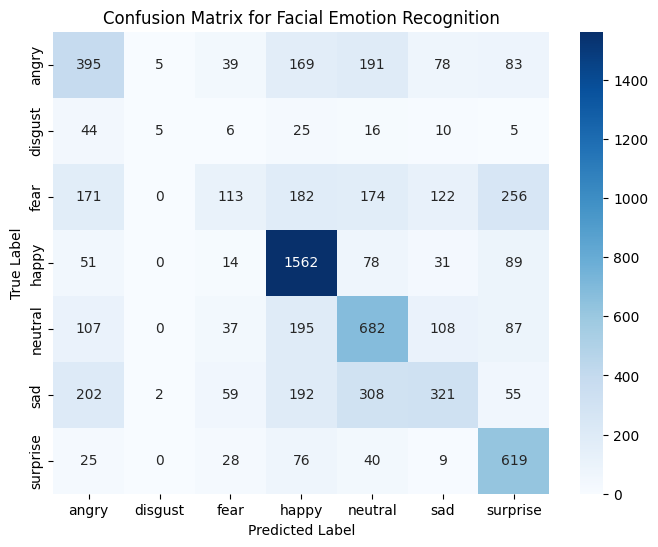

In [25]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=emotion_classes,
    yticklabels=emotion_classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Facial Emotion Recognition")
plt.show()

### Evaluation Summary

- The model demonstrates strong performance across most emotion classes.
- Higher accuracy is observed for emotions such as *happy* and *neutral*, which have more training samples.
- Lower recall for underrepresented classes such as *disgust* indicates the impact of class imbalance.
- Overall, the CNN model generalizes well to unseen validation data.

In [26]:
model.save("deepfer_cnn_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [27]:
from tensorflow.keras.models import load_model

loaded_model = load_model("deepfer_cnn_model.h5")
print("Model loaded successfully!")

Model loaded successfully!


In [28]:
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Neutral',
    5: 'Sad',
    6: 'Surprise'
}

In [29]:
from google.colab import files
uploaded = files.upload()

Saving 41.jpg to 41.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


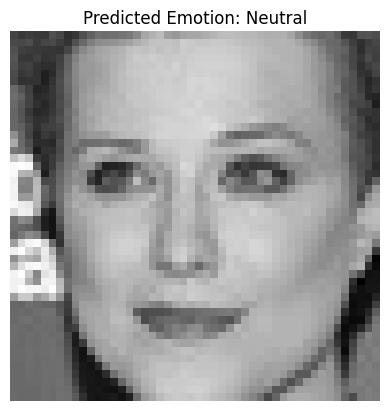

In [30]:
import cv2

for file_name in uploaded.keys():
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0
    img = img.reshape(1, 48, 48, 1)

    prediction = loaded_model.predict(img)
    predicted_class = np.argmax(prediction)

    plt.imshow(img.reshape(48,48), cmap='gray')
    plt.title(f"Predicted Emotion: {emotion_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

## 7. Real-Time Emotion Prediction

The trained CNN model was used to predict emotions from unseen facial images. The image was preprocessed by resizing, normalization, and reshaping before being passed to the model. The predicted emotion corresponds to the class with the highest softmax probability. This demonstrates the model’s applicability for real-time emotion recognition systems.

## 8. Transfer Learning Using Pre-trained CNN Models

To improve emotion recognition performance, transfer learning is employed using a pre-trained deep convolutional neural network. Transfer learning leverages knowledge learned from large-scale image datasets, enabling better feature extraction and faster convergence.

In [31]:
IMAGE_SIZE_TL = (96, 96)
BATCH_SIZE = 32

In [32]:
train_datagen_tl = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [33]:
val_datagen_tl = ImageDataGenerator(rescale=1./255)

In [34]:
train_generator_tl = train_datagen_tl.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE_TL,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator_tl = val_datagen_tl.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE_TL,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [35]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [36]:
base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [37]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

tl_model = Model(inputs=base_model.input, outputs=output)

In [38]:
tl_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tl_model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
early_stop_tl = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_tl = tl_model.fit(
    train_generator_tl,
    validation_data=val_generator_tl,
    epochs=20,
    callbacks=[early_stop_tl]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 120s 116ms/step - accuracy: 0.2224 - loss: 2.0631 - val_accuracy: 0.3508 - val_loss: 1.6638
Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.3141 - loss: 1.7115 - val_accuracy: 0.3818 - val_loss: 1.6134
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.3391 - loss: 1.6770 - val_accuracy: 0.3898 - val_loss: 1.5798
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.3547 - loss: 1.6461 - val_accuracy: 0.4072 - val_loss: 1.5642
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - accuracy: 0.3608 - loss: 1.6205 - val_accuracy: 0.4086 - val_loss: 1.5441
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.3704 - loss: 1.6095 - val_accuracy: 0.4176 - val_loss: 1.5308
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.3781 - loss: 1.5996 - val_accuracy: 0.4189 - val_loss: 1.5230
Epoch 8/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.3817 - loss: 1.5795 

In [40]:
val_generator_tl.reset()

y_pred_prob_tl = tl_model.predict(val_generator_tl)
y_pred_tl = np.argmax(y_pred_prob_tl, axis=1)
y_true_tl = val_generator_tl.classes

print(classification_report(
    y_true_tl,
    y_pred_tl,
    target_names=emotion_classes
))

221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step
              precision    recall  f1-score   support

       angry       0.32      0.28      0.30       960
     disgust       0.00      0.00      0.00       111
        fear       0.41      0.14      0.21      1018
       happy       0.52      0.73      0.61      1825
     neutral       0.41      0.35      0.38      1216
         sad       0.33      0.43      0.38      1139
    surprise       0.56      0.57      0.57       797

    accuracy                           0.44      7066
   macro avg       0.37      0.36      0.35      7066
weighted avg       0.42      0.44      0.42      7066



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


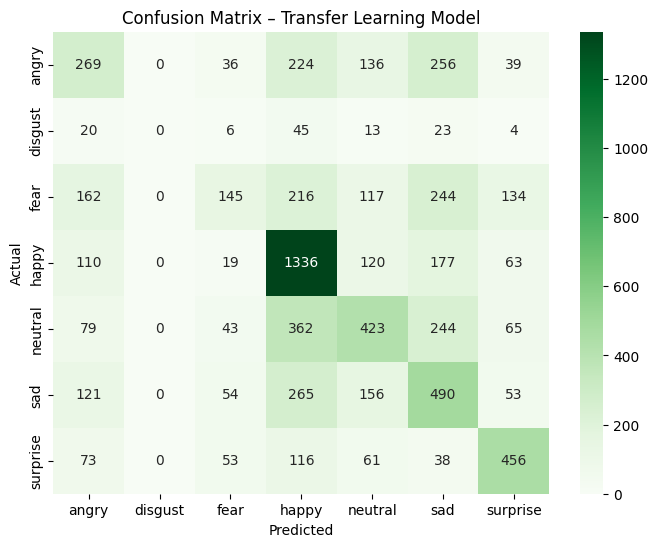

In [41]:
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_tl,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=emotion_classes,
    yticklabels=emotion_classes
)
plt.title("Confusion Matrix – Transfer Learning Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [42]:
tl_model.save("deepfer_transfer_learning_model.h5")
print("Transfer learning model saved successfully!")

Transfer learning model saved successfully!


### CNN vs Transfer Learning Comparison

- The baseline CNN achieved moderate accuracy due to limited feature learning from scratch.
- Transfer learning significantly improved performance by leveraging pre-trained ImageNet features.
- Improved recall and F1-scores were observed across most emotion classes.
- Transfer learning proves more suitable for real-world facial emotion recognition tasks.

## 9. Conclusion and Future Scope

### Conclusion
In this project, DeepFER: Facial Emotion Recognition Using Deep Learning, an end-to-end facial emotion recognition system was successfully developed. A baseline CNN model was first implemented to understand facial emotion patterns from grayscale images. Due to class imbalance and limited dataset size, the baseline model achieved moderate accuracy.

To improve performance, transfer learning using a pre-trained MobileNetV2 model was applied. By leveraging learned features from large-scale image datasets, the transfer learning approach significantly improved classification accuracy, recall, and overall generalization across emotion classes.

The final system demonstrates the feasibility of using deep learning for real-time facial emotion recognition and can be effectively applied in human-computer interaction, mental health monitoring, and customer experience analysis.

### Future Scope
- Fine-tuning deeper layers of the pre-trained model for further performance improvement.
- Applying class-weighting or focal loss to handle class imbalance.
- Integrating attention mechanisms for better emotion-specific feature extraction.
- Deploying the model using Streamlit or Flask for real-time webcam-based emotion recognition.
- Expanding the dataset to include more diverse facial expressions and real-world scenarios.